In [7]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sys import exit
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
import statsmodels.regression.linear_model as sm
from sklearn.ensemble import GradientBoostingRegressor
import datetime
from scipy.optimize import leastsq
    
df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv",encoding = "ISO-8859-1")

filter=df["state"].isin(['Colorado','Idaho','Utah'])
df=df[filter]
filter=df["date"]>='2020-07-1'
df=df[filter]
df=df.sort_values(['county'],ascending=True)
#print("deaths by county " +str(df.groupby(["state","county",'date'])["cases","deaths"].agg([max])))



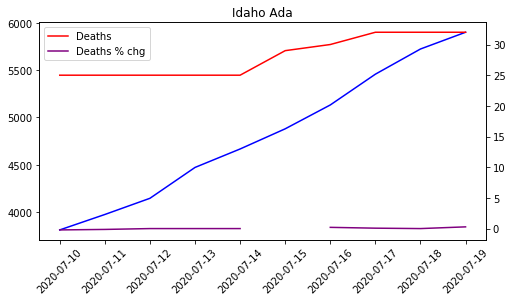

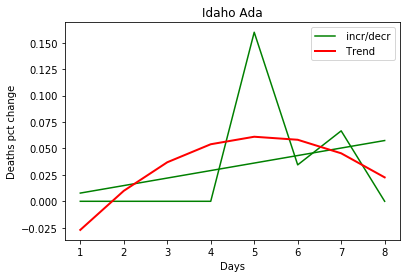

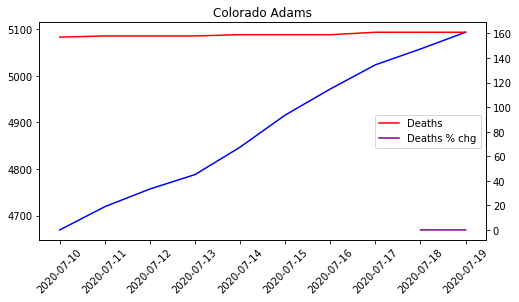

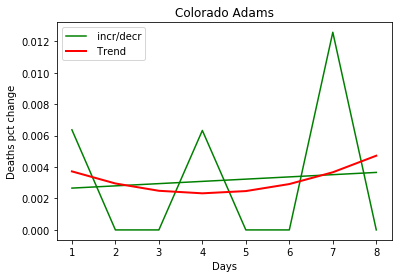

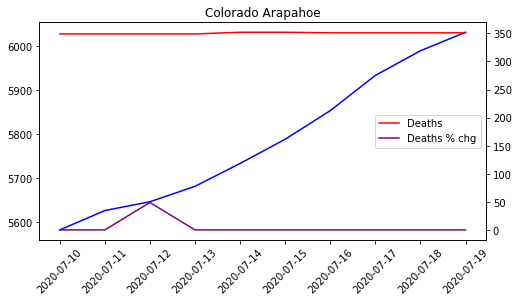

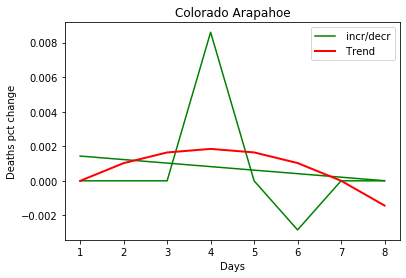

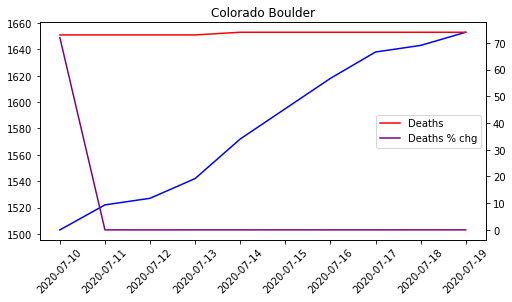

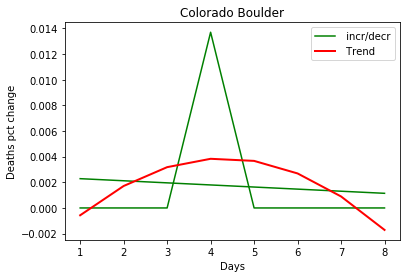

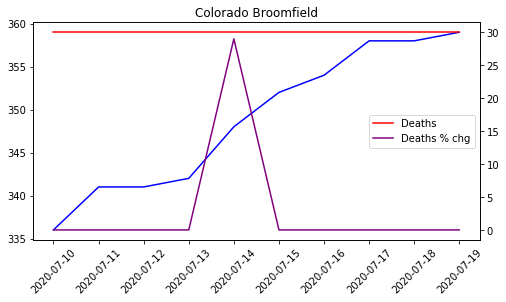

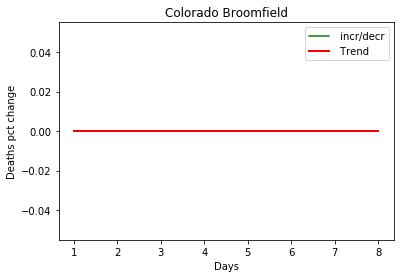

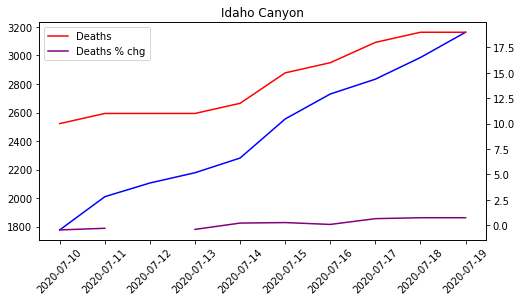

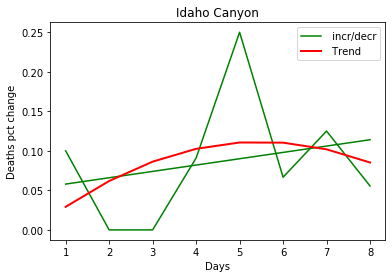

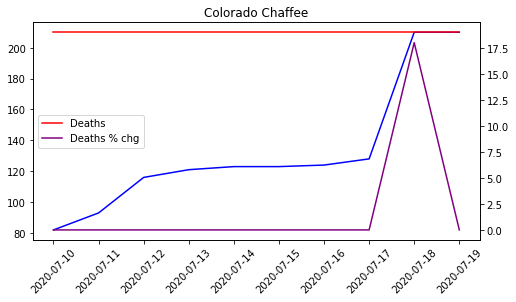

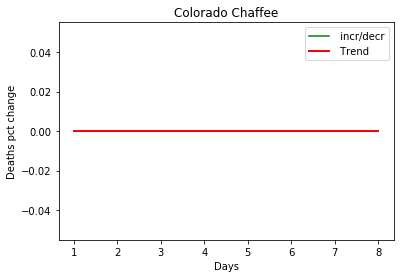

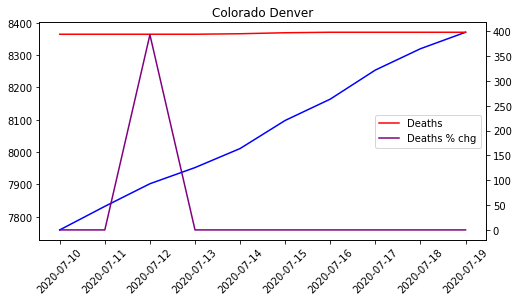

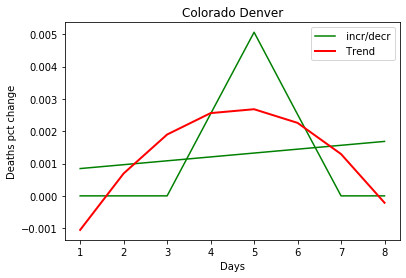

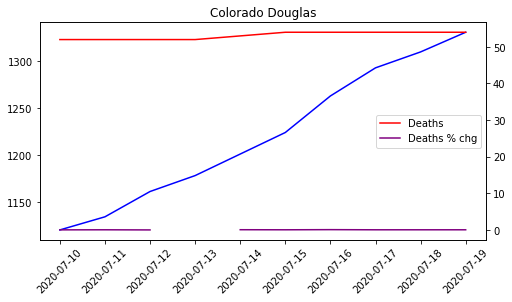

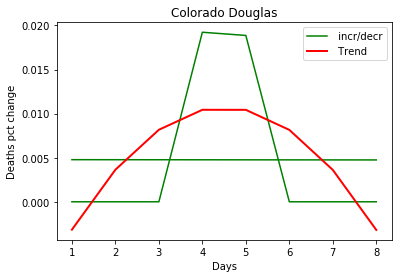

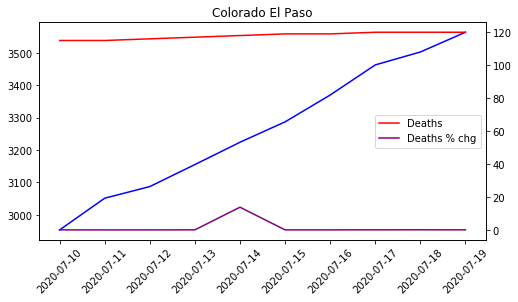

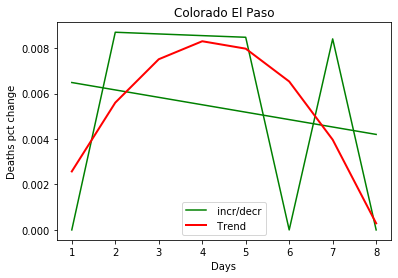

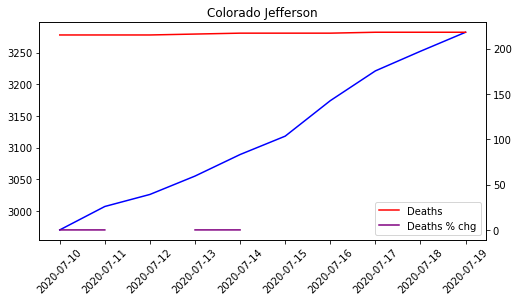

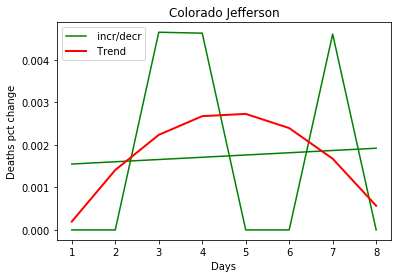

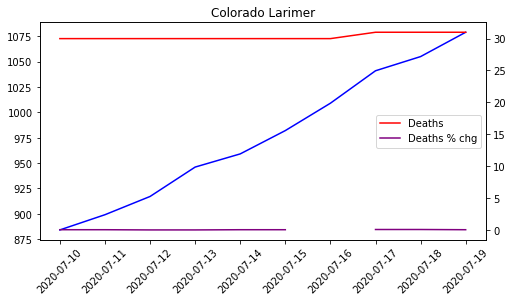

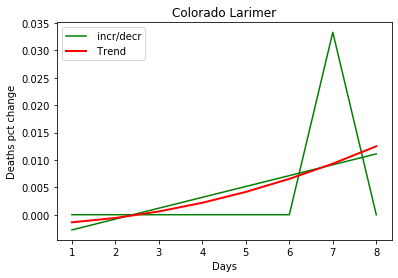

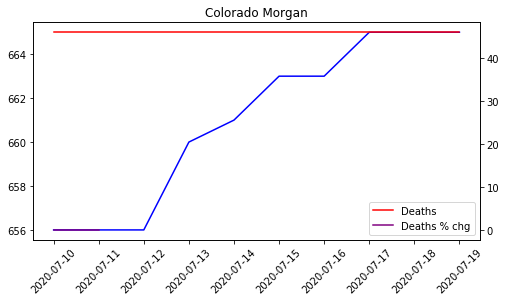

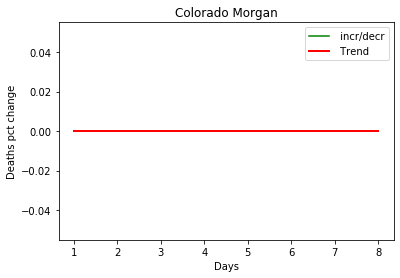

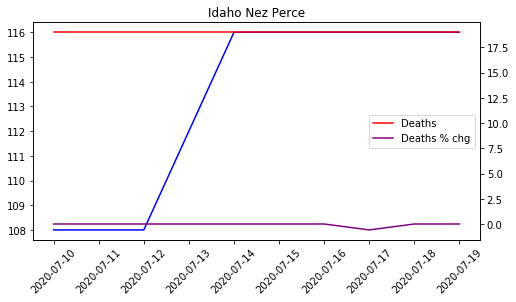

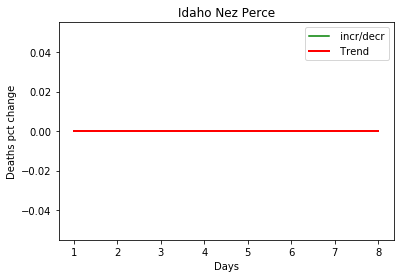

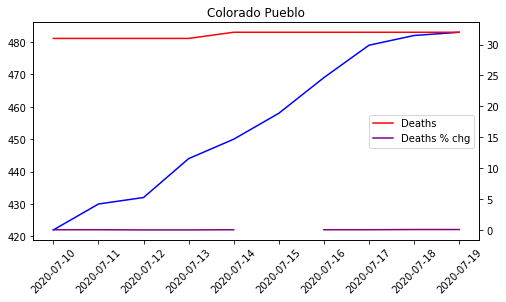

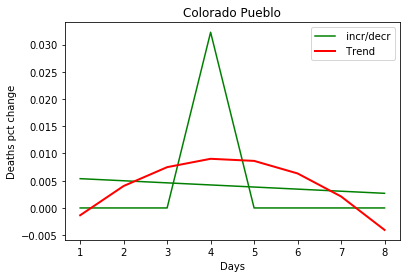

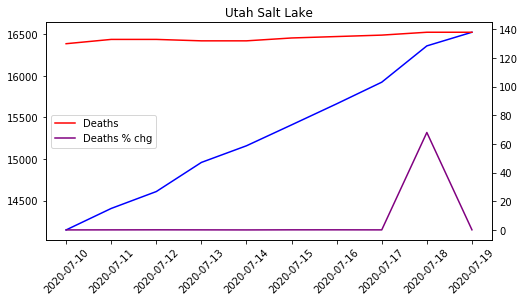

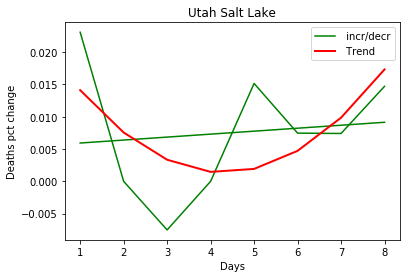

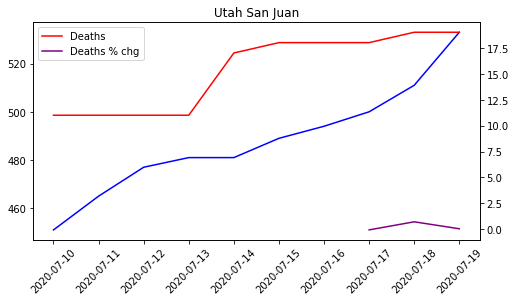

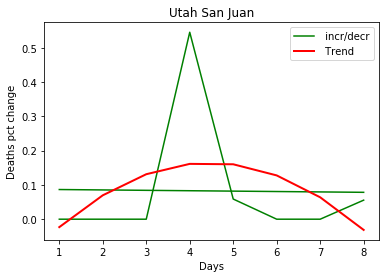

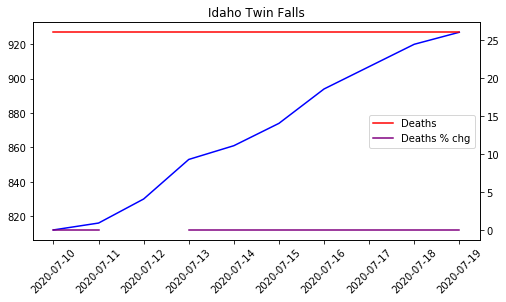

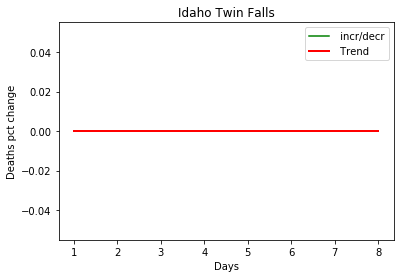

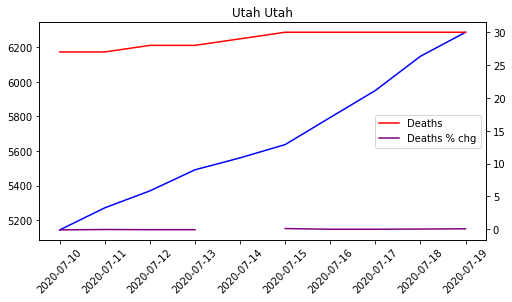

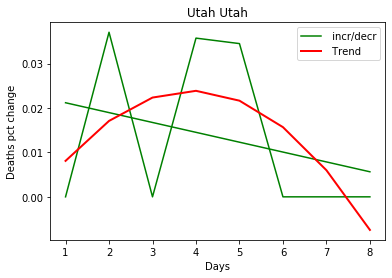

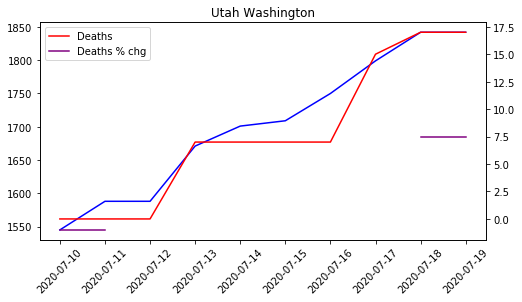

ValueError: operands could not be broadcast together with shapes (6,) (8,) 

In [10]:
def LeastSquareApproximation(x,y):
    xy=y*x
    xx=x**2
    n=len(x)
    sum_x=x.sum()
    x_mean=x.mean()
    y_mean=y.mean()
    sum_y=y.sum()
    sum_xy=(x*y).sum()
    sum_xx=(x * x).sum()
    #print("sum_x:"+str(sum_x))
    #print("sum_y:"+str(sum_y))
    #print("sum_xy:" + str(sum_xy))
    #print("sum_xx:"+str(sum_xx))
    b=(sum_xy - n * x_mean * y_mean) / (sum_xx -  n * x_mean * x_mean)
    a=y_mean - b * x_mean
    #print(xy)
    #print(xx)
    yfit=a+b*x
    #print(yfit)
    return yfit

def func(params, x):
 a, b, c = params
 return a * x * x + b * x + c


# Error function, that is, the difference between the value obtained by fitting curve and the actual value
def error(params, x, y):
 return func(params, x) - y


# Solving parameters
def parabolicTrend(inputX,inputY):
 p0 = [10, 10, 10]

 Para = leastsq(error, p0, args=(inputX, inputY))
 return Para


df['state_county']=df['state']+" "+df['county']
df['cases_pct_change']=df['cases'].pct_change()
df['deaths_pct_change']=df['deaths'].pct_change()
deaths=df['deaths'].tolist()
cases=df['cases'].tolist()
counties=df['county'].tolist()
counties_filter=df.groupby(['state','county'])['deaths'].max()>15
counties_filter=counties_filter.loc[counties_filter.values==True]
counties=pd.merge(df,counties_filter,how='inner',on=['state','county'])
counties_df=counties[counties['deaths_y']==True]
counties_unique=counties_df['state_county'].unique()

rows=len(counties_unique)

index=0
deaths=[]
deaths_pct_change=[]
cases=[]
cases_pct_change=[]
index_date=[]

for item in counties_unique:
    subset_df=df[df['state_county']==item]
    dates=pd.to_datetime(subset_df['date']).dt.date
    dates=dates.unique()
    
    index=0
    for date in dates:
        subset_df=df[(df['state_county']==item) & (df['date']==str(date)) ]
        result=subset_df.groupby('date')['deaths'].first()
        deaths.append(result[0])
        
        result=subset_df.groupby('date')['cases'].first()
        cases.append(result[0])
        
        result=subset_df.groupby('date')['cases_pct_change'].first()
        cases_pct_change.append(result[0])

        result=subset_df.groupby('date')['deaths_pct_change'].first()
        deaths_pct_change.append(result[0])

        index_date.append(date)

    dict={
        'deaths':deaths,
        'deaths_pct_change': deaths_pct_change,
        'cases':cases,
        'cases_pct_change':cases_pct_change,
        'date':index_date
    }
    df_summary=pd.DataFrame(dict)
    df_summary=df_summary.sort_values('date')
    df_summary.set_index('date')
    #print(df_summary)
    
    fig,ax = plt.subplots(figsize=(8,4))
    ax.plot(df_summary['date'],df_summary['cases'],color='blue',label='Cases')

    ax2=ax.twinx()
    ax2.plot(df_summary['date'],df_summary['deaths'],color='red',label='Deaths')
    ax2.plot(df_summary['date'],df_summary['deaths_pct_change'],color='purple',label='Deaths % chg')
    index+=1
    ax.set_title(item)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    plt.legend()  
    plt.show()

    slope_deaths=df_summary['deaths'].iloc[-10:-1].pct_change()
    slope_deaths=slope_deaths.dropna()
    x=np.arange(1,9)
    yfit=LeastSquareApproximation(x,slope_deaths)
    
    plt.clf()
    plt.plot(x,yfit, label=' incr/decr',color='green')
    plt.plot(x,slope_deaths,color='green')
    plt.title(item)
    plt.xlabel('Days')
    plt.ylabel('Deaths pct change')
   
    Para = parabolicTrend(x,slope_deaths)
    a, b, c = Para[0]
    y = a * x * x + b * x + c # # function
    plt.plot(x,y,color="red",label=" Trend ",linewidth=2)
    plt.legend()
    plt.show()


    deaths.clear()
    deaths_pct_change.clear()
    cases.clear()
    cases_pct_change.clear()
    index_date.clear()

deaths_unique=counties_df.groupby(['county','date'])['deaths_x'].max()
cases_unique =counties_df.groupby(['county','date'])['cases'].max()
counties_unique=counties_df['county'].unique()

plt.hist(deaths_unique,bins=200)
plt.title('Deaths histogram')
plt.xlabel('Occurrences')
plt.ylabel('Deaths')

plt.show()

X_cases=np.array(cases_unique).reshape(-1,1)
y_deaths=np.array(deaths_unique).reshape(-1,1)
prediction_space=np.linspace(min(X_cases),max(X_cases)).reshape(-1,1)

model = linear_model.LinearRegression()
model.fit(X_cases, y_deaths)

SEED=1
gbt=GradientBoostingRegressor(n_estimators=300, max_depth=1, random_state=SEED)
gbt.fit(X_cases, y_deaths)  

prediction_space=np.linspace(min(X_cases),max(X_cases)).reshape(-1,1)

plt.clf()
plt.scatter(cases_unique,deaths_unique)
plt.plot(prediction_space,model.predict(prediction_space),c="green")

plt.plot(prediction_space,gbt.predict(prediction_space),c="red")
plt.title('Death predictions')
plt.xlabel('Deaths')
plt.ylabel('Cases')
plt.show()



In [11]:
#print(dates)
start_date=dates.min()

#start = '1/22/2020'
#start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forecast_dates = []

days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-10]

for i in range(len(future_forecast)):
    future_forecast_dates.append(
        (start_date + datetime.timedelta(days=i)
        ).strftime('%m/%d/%Y'))
    
#print(future_forecast_dates)
#print(adjusted_dates)

In [12]:
#def LeastSquareApproximation(x,y):
#    xy=y*x
#    xx=x**2
#    n=len(x)
#    sum_x=x.sum()
#    x_mean=x.mean()
#    y_mean=y.mean()
#    sum_y=y.sum()
#    sum_xy=(x*y).sum()
#    sum_xx=(x * x).sum()
#    #print("sum_x:"+str(sum_x))
#    #print("sum_y:"+str(sum_y))
#    #print("sum_xy:" + str(sum_xy))
#    #print("sum_xx:"+str(sum_xx))
#    b=(sum_xy - n * x_mean * y_mean) / (sum_xx -  n * x_mean * x_mean)
#    a=y_mean - b * x_mean
#    #print(xy)
#    #print(xx)
#    yfit=a+b*x
#    #print(yfit)
#    return yfit

#x=np.array([1,2,3,4,5,6,7])
#price=np.array([1,4,-7,-10.95,0,-5,-11])

#yfit=LeastSquareApproximation(x,price)

#prediction_space=np.linspace(min(price),max(price),len(price)).reshape(-1,1)
#plt.plot(x,price)
#ax=plt.twinx()
#ax.plot(x,yfit)
#plt.show()



In [13]:
from scipy import optimize

#x=np.array([1,2,3,4,5,6,7])
x=np.array([2006,2007,2008,2009,2010,2011,2012,2013])
#price=np.array([1,4,-7,-10.95,0,-5,-11])
price=np.array([5,8,13,11,15,18,17,21])
number_of_elements=len(x)

def ParabolicTrend(x,y,n):
    interval=1
    x_mean=x.mean()
    baseYear=np.median(x)
    #print(baseYear)
    x=(x-baseYear)/0.5*interval
    sum_x=x.sum()
    #print(x_mean)
    #x=x-x_mean
    #print(x)
    x_pow2=x**2
    x_pow3=x**3
    #print(x_pow2)
    sum_x_pow2=x_pow2.sum()
    #print(sum_x_pow2)
    x_pow4=x**4
    #print(x_pow4)
    sum_x_pow4=x_pow4.sum()
    x_times_y=x*y
    #print(x_times_y)
    sumx_times_sumy=x_times_y.sum()
    x_pow2_times_y=x**2*y
    #print(x_pow2_times_y)
    sum_x_pow2_times_y=x_pow2_times_y.sum()
    #print(sum_x_pow2_times_y)
    sum_y=price.sum()
    b=sumx_times_sumy/sum_x_pow2
    #print(b)
    #print(sum_y)
    #a=(sum_y-b*x-x_pow2)/n
    a=(sum_y-b*sum_x-sum_x_pow2)/n
    print(sum_x)
    print(sum_x_pow2)
    print(a)
    print(b)
    print(sum_x_pow2)
    a=16
    
    c=(sum_x_pow_2*sum_y-sum_x_pow_2*a*n)/sum_x_pow4
    print(c)
    print(c2)
    #c=-0.024
    y=a+b*x+c*x**2
    return y

#print(price[0])
#yfit=LeastSquareApproximation(x,price)
y=ParabolicTrend(x,price,number_of_elements)
plt.plot(x,price)
plt.plot(x,y)
#ax=plt.twinx()
#ax.plot(x,yfit)
plt.show()


0.0
168.0
-7.5
1.0476190476190477
168.0


NameError: name 'sum_x_pow_2' is not defined

-0.09523809526011284
2.952380952365564
2.6428571428411374


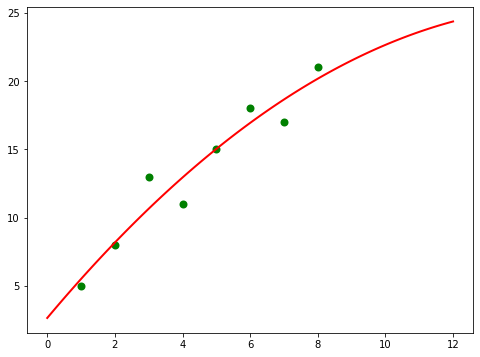

In [14]:
from scipy.optimize import leastsq

X=np.array([1,2,3,4,5,6,7,8])
Y=np.array([5,8,13,11,15,18,17,21])

#X = np.array([1,2,3,4,5,6])
#Y=np.array([9.1,18.3,32,47,69.5,94.8])

def func(params, x):
 a, b, c = params
 return a * x * x + b * x + c


# Error function, that is, the difference between the value obtained by fitting curve and the actual value
def error(params, x, y):
 return func(params, x) - y


# Solving parameters
def parabolicTrend(X,Y):
 p0 = [10, 10, 10]

 Para = leastsq(error, p0, args=(X, Y))
 return Para

def solution():
 Para = parabolicTrend(X,Y)
 a, b, c = Para[0]
 print(a)
 print(b)
 print(c)
 plt.figure(figsize=(8,6))
 plt.scatter(X, Y, color="green", label="sample data", linewidth=2)

 x = np. linspace (0, 12, 100) # draw 100 continuous points directly from 0 to 15
 y = a * x * x + b * x + c # # function
 plt.plot(x,y,color="red",label="solution line",linewidth=2)

 plt.show()
solution()